# Trans-dimensional Bayesian partition modelling of Eustatic Sea-level heights over time

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/linear_regression/linear_regression_sealevel.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

---

## What we do in this notebook

Here we demonstrate use of CoFI on a real dataset **linear regression** problem, where we fit a partition model to Eustatic Sea-level heights using trans-D Bayesian partition modelling

---

Data set is from

**Sea level and global ice volumes from the Last Glacial Maximum to the Holocene**, K. Lambeck, H. Rouby, A. Purcell, Y. Sun, and M. Sambridge, 2014. 
Proc. Nat. Acad. Sci., 111, no. 43, 15296-15303, doi:10.1073/pnas.1411762111.

In [1]:
# Environment setup (uncomment code below)

# !pip install -U cofi
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/linear_regression

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

## Partition modelling

We read in the Eustatic sea-level heights over time as (x,y) data. y is height, x is time in k.a. before present.

In [3]:
# load x,y data
def load_data_xy(filename):
    x, y, sx, sy = np.loadtxt(filename, skiprows=1).T
    sy /= 2  # input data are 2 sigma and we require sigma
    return x, y, sy

def load_data_ref(filename):

    f = open(filename, 'r')
    lines = f.readlines()
    dx = np.array([]) # Age data
    dy = np.array([]) # ESL height
    dz = np.array([]) # derivative of ESL w.r.t. age
    for line in lines:
        columns = line.split()
        dx = np.append(dx,float(columns[0]))
        dy = np.append(dy,float(columns[1]))
    datavals = np.column_stack((dx,dy))  # Stack data

    return datavals

In [4]:
data_x,data_y,sy = load_data_xy("../../data/eustatic_sea_level/ESL-ff11-sorted.txt")  # Load x,sx,y,sy ESL data (x=time, Y=ESL)

In [5]:
maxtime = 20. # maximum time before present being used in data (measured in $10^3$ years)
idata = np.flatnonzero(data_x < maxtime) # indices of data to be used

In [6]:
data_x,data_y,sy = data_x[idata],data_y[idata],sy[idata]

And now lets plot the data with uncertainties

In [7]:
def plot_data(x=data_x,y=data_y,sigma=sy,title=None):
    fig, axes = plt.subplots(figsize=(9,6))
    plt.errorbar(x, y, yerr=sy, fmt='.',color="lightcoral",ecolor='lightgrey',ms=2)
    plt.xlabel(' Time before present (ka)')
    plt.ylabel(' ESL height (m)')
    if(title != None): plt.title(title)

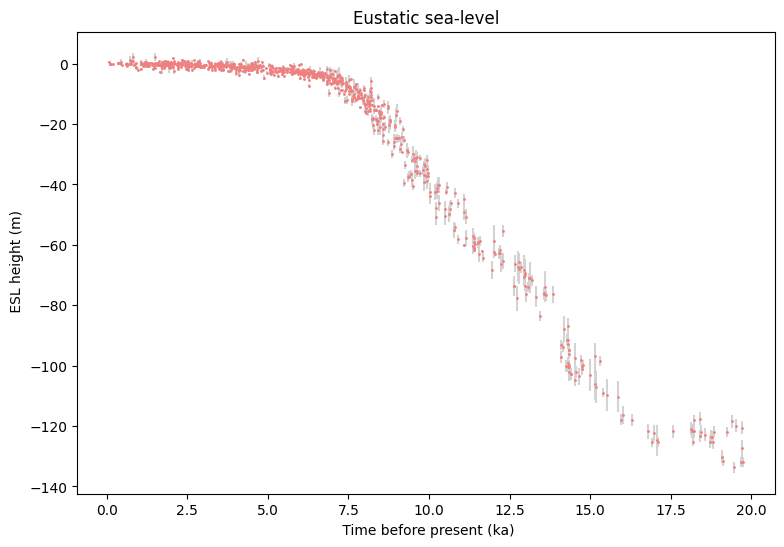

In [8]:
# plot Eustatic sea-level data
plot_data(title='Eustatic sea-level')

## Problem description

The partition representation of the sea level curve corresponds to a linear segmented curve of sea-level height over time. The unknowns are the heights and positions of a set of (x,y) points where linear polynomials are drawn between them. This is illustrated by the following figure

<p align="center">
  <img width="50%" src="../../data/eustatic_sea_level/Partition_modelling_setup.png">
</p>

<p>&nbsp;</p>
Here the blue lines represent the linear segment model for a particular curve with five partitions [Figure from Lambeck et al. (2013)]. For a model wth $n$ partitions there are $(n+1)$ heights (y) and $(n-1)$ interface locations (x) that are treated as unknown. In a trans-D set up $n$ is also unknown and varies during the sampling.



To constrain the trans-dimensional partition model we have a set of noisy data values, $y_i (i=0,\dots,N)$, measured at known locations, $x_i (i=0,\dots,N)$, and wish to find the best fit degree 3 polynomial.

The height measurements is assumed to have independent Gaussian random noise, ${\cal N}(0,\Sigma)$, with $(\Sigma)_{ij} = \delta_{ij}/\sigma_i^2$, where the variance of the noise on each datum, $\sigma_i^2 (i=1,\dots,N)$, differs between observations and is given.

Define a reference model for later.

In [9]:
# Reference model for plotting
ESLref = load_data_ref("../../data/eustatic_sea_level/ESL-f11_yonly.txt") # Load x, y, z reference model and estimated derivative (x=time, Y=ESL, z=dESL/dt) 
ndata2 = np.where(ESLref.T[0]>maxtime)[0][0]
ESLref = ESLref[:ndata2]
ref_x,ref_y = ESLref.T[0],ESLref.T[1]

Now lets plot the data with the reference curve

In [10]:
# Some plotting utilities
def plot_model(x,y, label, color=None,lw=0.5):
    plt.plot(x, y, color=color or "green", label=label,lw=lw)
    #plt.xlabel("X")
    #plt.ylabel("ESL")
    plt.legend()

def plot_models(models, label="Posterior samples", color="seagreen", alpha=0.1,lw=0.5):
    G = jacobian(data_x)
    plt.plot(data_x, G.dot(models[0]), color=color, label=label, alpha=alpha,lw=lw)
    for m in models:
        plt.plot(data_x, G.dot(m), color=color, alpha=alpha,lw=lw)
    plt.legend()

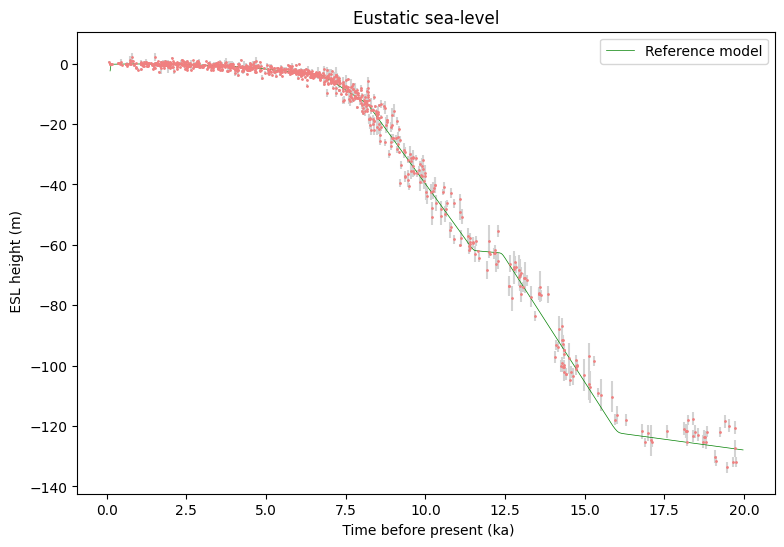

In [11]:
plot_data(title="Eustatic sea-level")
plot_model(ref_x,ref_y, "Reference model")

Now we have the data and the forward model we can start to try and estimate the coefficients from trans-D sampling.

## The structure of CoFI <a name="CoFI-structure"></a>
In the workflow of `cofi`, there are three main 
components: `BaseProblem`, `InversionOptions`, and `Inversion`.

- `BaseProblem` defines the inverse problem including any user supplied quantities such as data vector, number of model parameters and measure of fit between model predictions and data. 
    ```python
    inv_problem = BaseProblem()
    inv_problem.set_objective(some_function_here)
    inv_problem.set_jacobian(some_function_here)
    inv_problem.set_initial_model(a_starting_point) # if needed, e.g. we are solving a nonlinear problem by optimization
    ```
    
    &nbsp; 
- `InversionOptions` describes details about how one wants to run the inversion, including the backend tool and solver-specific parameters. It is based on the concept of a `method` and `tool`.

    ```python
    inv_options = InversionOptions()
    inv_options.suggest_solving_methods()
    inv_options.set_solving_method("matrix solvers")
    inv_options.suggest_tools()
    inv_options.set_tool("scipy.linalg.lstsq")
    inv_options.summary()
    ```

    &nbsp; 
- `Inversion` can be seen as an inversion engine that takes in the above two as information,
  and will produce an `InversionResult` upon running.
  
    ```python
    inv = Inversion(inv_problem, inv_options)
    result = inv.run()
    ```
 
 Internally CoFI decides the nature of the problem from the quantities set by the user and performs internal checks to ensure it has all that it needs to solve a problem.

-------

## 3. Bayesian sampling


### Likelihood

Since data errors follow a Gaussian in this example, we can define a Likelihood function, $p({\mathbf d}_{obs}| {\mathbf m})$. 

$$
p({\mathbf d}_{obs} | {\mathbf m}) \propto \exp \left\{- \frac{1}{2} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m}))^T C_D^{-1} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m})) \right\}
$$

where ${\mathbf d}_{obs}$ represents the observed sea-level heights and ${\mathbf d}_{pred}({\mathbf m})$ are those predicted by the partition model unknowns $({\mathbf m})$, where

$$
{\mathbf m} = \left( n, y_1,y_2,\dots,y_{n+1}; x_1, x_2,\dots, x_{n-1} \right)^T
$$

The Likelihood is defined as the probability of observing the data actually observed, given a model. In practice we usually only need to evaluate the log of the Likelihood, $\log p({\mathbf d}_{obs} | {\mathbf m})$.
To do so, we require the inverse data covariance matrix describing the statistics of the noise in the data, $C_D^{-1}$ . For this problem the data errors are independent with identical standard deviation in noise for each datum. Hence $C_D^{-1} = \frac{1}{\sigma^2}I$ where $\sigma=1$.

### Prior

Trans-D Bayesian sampling requires a prior probability density function for all unknowns. Here we choose a uniform prior for both sea-level heights, y, and partition locations, x, within specified bounds

$$
\begin{align}
p({\mathbf m}) &= \frac{1}{V},\quad  l_i \le m_i \le u_i, \quad (i=1,\dots,2n)\\
\\
         &= 0, \quad {\rm otherwise},
\end{align}
$$

where $l_i$ and $u_i$ are lower and upper bounds on the $i$th unknown, and $V$ is a normalization constant, $V = \prod_{i=1}^{2n} (u_i-l_i)$. We also use a uniform prior over the number of partitions $1\le n \le N_{max}$.



Note that the user could specify **any appropriate Prior PDF** of their choosing here.

### Trans-D Bayesian sampling

In this approach we sample a probability distribution rather than find a single best fit solution. Bayes' theorem tells us the the posterior distribution is proportional to the Likelihood and the prior.

$$p(\mathbf{m}, n|\mathbf{d}) = K p(\mathbf{d}|\mathbf{m}, n)p(\mathbf{m}|n)p(n)$$

where $K$ is some constant. Under the assumptions specified $p(\mathbf{m}|\mathbf{d})$ gives a probability density of models that are supported by the data. We seek to draw random samples from $p(\mathbf{m}, n|\mathbf{d})$ over the variably dimensioned model space and then to make inferences from the resulting ensemble of model parameters.

In this example we make use of *The BayesBay sampler* to sample the
posterior distribution. (For more details see [bayesbay](https://bayes-bay.readthedocs.io/en/latest/index.html)).

----

### Import cofi and trans-D software utilities


In [12]:
import cofi
from bayesbay.discretization import Voronoi1D
from bayesbay.likelihood import Target, LogLikelihood
from bayesbay.prior import UniformPrior
from bayesbay.parameterization import ParameterSpace, Parameterization

### Define nature of variables and their prior PDFs

Now we define the types of variables used in the trans-D parameterzation of a linear segment curve.

In [13]:
# height variables y
y_range = data_y.max() - data_y.min()
y_start = UniformPrior(
    "y_start", vmin=data_y[0] - 5, vmax=data_y[0] + 5, perturb_std=0.5
)
y_end = UniformPrior("y_end", vmin=data_y[-1] - 5, vmax=data_y[-1] + 5, perturb_std=0.5)
# x_inner = UniformPrior("x_inner", vmin=0, vmax=maxtime, perturb_std=maxtime / 20)
y_inner = UniformPrior(
    "y_inner", vmin=data_y.min() - 5, vmax=data_y.max() + 5, perturb_std=y_range / 20
)

In [14]:
# using the 1D Voronoi setup to produce an interface parameterization with height variables within each
pspace_inner = Voronoi1D(
    name="pspace_inner",
    vmin=0,
    vmax=maxtime,
    perturb_std=maxtime / 20,
    n_dimensions=None,
    n_dimensions_min=1,
    n_dimensions_max=15,
    parameters=[y_inner],
)
pspace_outer = ParameterSpace(
    name="pspace_outer",
    n_dimensions=1,
    parameters=[y_start, y_end],
)
parameterization = Parameterization([pspace_inner, pspace_outer])

### Define function to evaluate the linear segment curve 

This returns the heights of the linear segment model at the x locations of the data.

In [15]:
def fwd_function(state):
    global data_x

    # Control points at coordinates x and y
    x = np.concatenate(
        ([data_x[0]], state["pspace_inner"]["discretization"], [data_x[-1]])
    )
    y = np.concatenate(
        (
            state["pspace_outer"]["y_start"],
            state["pspace_inner"]["y_inner"],
            state["pspace_outer"]["y_end"],
        )
    )

    y_pred = np.zeros(data_x.size)
    for i in range(x.size - 1):
        # ith and (i+1)th control points
        x1, y1 = x[i], y[i]
        x2, y2 = x[i + 1], y[i + 1]

        dx = x2 - x1
        dy = y2 - y1

        # Get data between x2 and x1
        idata = np.flatnonzero((data_x >= x1) & (data_x < x2))
        dx_data = data_x[idata] - x1
        y_pred[idata] = y1 + dy / dx * dx_data

    # Handle last point
    y_pred[-1] = y[-1]
    return y_pred


target = Target("d_obs", data_y, covariance_mat_inv=1 / sy**2)

log_likelihood = LogLikelihood(targets=target, fwd_functions=fwd_function)

### Starting points for random walkers

Now we define the number of walkers and their starting positions.

In [16]:
# initialize walkers
n_chains = 10 # number of Markov chains
walkers_start = []
for i in range(n_chains):
    walkers_start.append(parameterization.initialize())

### Setup and run CoFI

In [17]:
# initialize walkers
n_chains = 10
walkers_start = []
for i in range(n_chains):
    walkers_start.append(parameterization.initialize())

# run the sampling
inv_problem = cofi.BaseProblem()
inv_options = cofi.InversionOptions()
inv_options.set_tool("bayesbay")
inv_options.set_params(
    log_like_ratio_func=log_likelihood,
    perturbation_funcs=parameterization.perturbation_funcs,
    walkers_starting_states=walkers_start,
    n_chains=n_chains,
    n_cpus=n_chains,
    n_iterations=500_000,
    burnin_iterations=100_000,
    save_every=100,
    verbose=False,
)
inversion = cofi.Inversion(inv_problem, inv_options)
inv_result = inversion.run()
results = inv_result.models
y_pred = np.array(results["d_obs.dpred"])

percentiles = 10, 90
statistics = {
    "mean": np.mean(y_pred, axis=0),
    "median": np.median(y_pred, axis=0),
    "percentiles": np.percentile(y_pred, percentiles, axis=0),
}

/Users/malcolm/base/lib/python3.12/site-packages/cofi/tools/_base_inference_tool.py:273: UserWarning: the following options are defined but not in parameter list for the chosen tool: ['n_cpus']
  warnings.warn(


### Plotting the posterior ensemble of curves

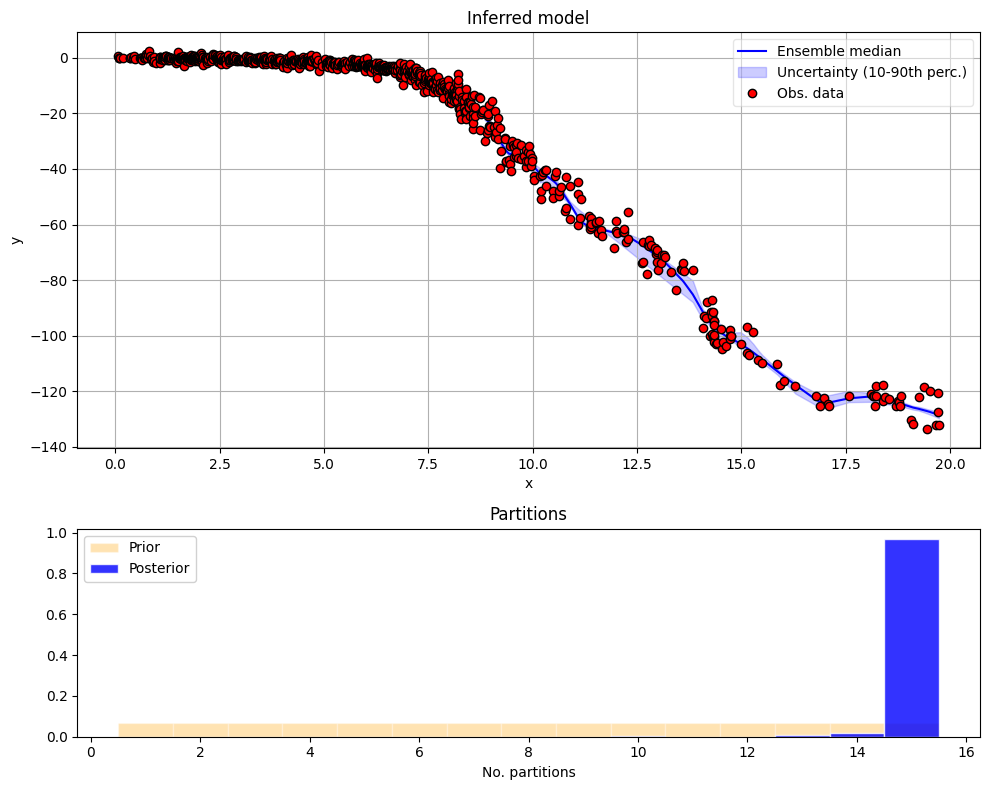

In [18]:
# Plotting

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])

ax1 = plt.subplot(gs[0, :])  # First row, spans all columns
ax2 = plt.subplot(gs[1, :])  # Second row, first column

ax1.plot(data_x, statistics["median"], "b", label="Ensemble median")
ax1.fill_between(
    data_x,
    *statistics["percentiles"],
    color="b",
    alpha=0.2,
    label="Uncertainty (%s-%sth perc.)" % (percentiles),
)
ax1.plot(data_x, data_y, "ro", markeredgecolor="k", label="Obs. data")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.legend(framealpha=0.5)
ax1.grid()
ax1.set_title("Inferred model")


ndim_min, ndim_max = pspace_inner._n_dimensions_min, pspace_inner._n_dimensions_max
ax2.hist(
    np.arange(ndim_min, ndim_max + 1),
    bins=np.arange(ndim_min - 0.5, ndim_max + 1.5),
    alpha=0.3,
    density=True,
    color="orange",
    ec="w",
    label="Prior",
)
ax2.set_xlabel("No. partitions")
ax2.hist(
    results["pspace_inner.n_dimensions"],
    bins=np.arange(ndim_min - 0.5, ndim_max + 1.5),
    color="b",
    alpha=0.8,
    density=True,
    ec="w",
    label="Posterior",
)
ax2.legend(framealpha=0)
ax2.set_title("Partitions")

ax2.legend(framealpha=0.9)
plt.tight_layout()
plt.show()


---

## Watermark

In [19]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.9
numpy 2.0.1
scipy 1.14.0
matplotlib 3.9.0
emcee 3.1.6
arviz 0.19.0
